# Bibliotecas

In [1]:
# Mudar diretório para chamar scripts com funções
import os
os.chdir('/home/francisco/MECAD/2º Ano/Estágio/forcera/scripts/scripts_py')

# Importar funções e flags definidas em flags.py e functions.py
from functions import *
from flags import * 

import psycopg2
from psycopg2 import OperationalError
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
import seaborn as sns
from IPython.display import HTML
import webbrowser
from collections import defaultdict
import networkx as nx

plt.rcParams['figure.figsize'] = (7,5)

# Ligação à base de dados

In [2]:
conn = psycopg2.connect(
    host = "contratos-base-gov1.cf87yxnqgph8.eu-central-1.rds.amazonaws.com",
    port = 5432,
    #database = "contratosbasegov",
    user = "contratosbasegov",
    password = "8n9nyeTBFUyCcLJShNrZdPUai2KQkue4")

cur = conn.cursor()

# DataFrame

In [3]:
# Filtrar contratos : ID's concursos públicos com CPV's começados por 72
cpub = (cpv('72', 'Concurso público'))

In [4]:
# Dataframe referente ao conjuntos de contratos públicos celebrados no ramo de consultoria IT 
cp = contratos(cpub)

In [5]:
# A tabela é representada de forma correta : o id do anúncio bate certo com o preço base, contratual e restantes colunas que são relevantes
# Contudo, a ordem dos ID's em cpub é diferente da ordem dos ids na coluna ID da dataframe
# A ordem os id's guardados na variável cpub não bate certo
# Na célula a seguir a esta, é preciso redefini-la
cp = cp.rename(columns={0:'ID', 1:'NrAnuncio', 2:'PrecoBase', 3:'Prazo', 16:'DataPub', 17:'DataCel', 18:'PrecoContratual',20:'Adjudicante', 22:'Adjudicatária' ,23:'EntConcorrentes'})

cp.PrecoBase = cp.PrecoBase.replace('None',0).astype(float)
cp.PrecoContratual = cp.PrecoContratual.replace('None',0).astype(float)

# R049 : Determinar número de concursos públicos celebrados por uma determinada entidade num determinado período de tempo 

- [x] Colunas Adjudicante e Ajudicatária : Separar elementos de cada uma das colunas em 3 colunas ( Entidade | URL | NIF )
- [x] Contar número de ocorrências para NIF nos dois casos ( adjudicante e adjudicatária )
- [x] Aplicar passo anterior num intervalo de tempo 

In [6]:
# Separação dos elementos de cada coluna em Entidade-NIF-URL
# O objetivo é contar o número de ocorrências de cada NIF
pattern = r'^(?P<EntidadeAdjudicante>.*?)\s?\((?P<NIF1>[\w\.-]+)\)\((?P<URL1>.*?)\)$'
pattern1 = r'^(?P<EntidadeAdjudicataria>.*?)\s?\((?P<NIF2>[\w\.-]+)\)\((?P<URL2>.*?)\)$'


Df_extracted =  cp['Adjudicante'].str.extract(pattern)
Df_extracted1 = cp['Adjudicatária'].str.extract(pattern1)


# Correr linhas abaixo só uma vez
# Caso contrário está sempre a adicionar à dataframe as mesas colunas
cp = pd.concat([cp, Df_extracted], axis=1)
cp = pd.concat([cp, Df_extracted1], axis=1)

In [7]:
h(cp.head(5))

ID,NrAnuncio,PrecoBase,Prazo,4,5,6,7,8,9,10,11,12,13,14,15,DataPub,DataCel,PrecoContratual,19,Adjudicante,21,Adjudicatária,EntConcorrentes,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,EntidadeAdjudicante,NIF1,URL1,EntidadeAdjudicataria,NIF2,URL2
10323405,15555/2023,137670.00,6,False,6699898,13437191,2023-09-19,182,2,False,False,https://dre.pt/application/file/221829278,Anúncio de procedimento,Concurso público,Contratualização de uma Plataforma Educacional de Aprendizagem Digital,2023-11-02,2023-10-31,113524.80,332,Município de Santarém (505941350)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1785),"Artigo 20.º, n.º 1, alínea b) do Código dos Contratos Públicos","Porto Editora, S.A. (500221103)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=585)",None,https://www.base.gov.pt/Base4/pt/detalhe/?type=anuncios&id=356587,https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjgwNTc4,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071168&ext=.pdf,false,72212190-7,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços de desenvolvimento de software para ensino,Principal,113524.8,Contratualização de uma Plataforma Educacional de Aprendizagem Digital,Não aplicável,None,"Portugal, Santarém, Santarém",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1699382733,Município de Santarém,505941350,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1785,"Porto Editora, S.A.",500221103,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=585
10322139,13241/2023,592500.00,36,False,6640568,13311154,2023-08-04,151,2,False,False,https://dre.pt/application/file/216770781,Anúncio de procedimento,Concurso público,"Concurso Público, com Publicidade Internacional, para a Aquisição de Serviços de instalação e manutenção de uma infraestrutura tecnológica em ""cloud"" de suporte ao sistema de informação aplicacional Oracle da LIPOR",2023-11-02,2023-11-02,521150.00,547,Associação de Municípios para a Gestão Sustentável de Resíduos do Grande Porto - LIPOR (501394192)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=390),"Artigo 20.º, n.º 1, alínea a) do Código dos Contratos Públicos","OPTIMIZER – SERVIÇOS E CONSULTADORIA INFORMÁTICA, LDA. (504775936)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=10540)",None,https://www.base.gov.pt/Base4/pt/detalhe/?type=anuncios&id=353643,https://community.vortal.biz/PRODPublic/Tendering/OpportunityDetail/Index?noticeUID=PT1.NTC.2501553,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2070929&ext=.pdf,false,72300000-8,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços relacionados com dados,Principal,521150.0,"Concurso Público, com Publicidade Internacional, para a Aquisição de Serviços de instalação e manutenção de uma infraestrutura tecnológica em ""cloud"" de suporte ao sistema de informação aplicacional Oracle da LIPOR",Não aplicável,None,"Portugal, Porto, Gondomar",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1699384415,Associação de Municípios para a Gestão Sustentável de Resíduos do Grande Porto - LIPOR,501394192,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=390,"OPTIMIZER – SERVIÇOS E CONSULTADORIA INFORMÁTICA, LDA.",504775936,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=10540
10324626,15934/2023,150151.14,3,False,6708714,13455812,2023-09-25,186,2,False,False,https://dre.pt/application/file/222052596,Anúncio de procedimento,Concurso público,Concurso público para a aquisição/renovação da manutenção e atualização de licenças software Microsoft Enterprise Agreement n.º 5124030,2023-11-03,2023-10-25,150436.

In [8]:
# Contagem do número de ocorrências para os NIFs de entidades adjudicantes
cp.NIF1.value_counts()

NIF1
509540716    348
508184509     50
504322915     33
510928374     29
510361242     28
            ... 
900106590      1
501460888      1
600084809      1
600086992      1
600081028      1
Name: count, Length: 310, dtype: int64

In [9]:
# Contagem do número de ocorrências para os NIFs de entidades adjudicatárias
cp.NIF2.value_counts()

NIF2
504272179         96
501774360         85
515777048         54
502604751         53
510728189         43
                  ..
504441361          1
502876581          1
NL856689439B01     1
513854363          1
507477740          1
Name: count, Length: 320, dtype: int64

In [10]:
# Conversão das colunas de data de celebração e publicação em datetime
cp.DataCel = pd.to_datetime(cp.DataCel)
cp.DataPub = pd.to_datetime(cp.DataPub)

In [11]:
# Número de contratos celebrados em 2023
len(cp[cp['DataCel'].dt.year == 2023])

718

In [12]:
# Como há NIFs estrangeiros que contém as letras do país antes do número, temos de comparar strings e não inteiros
cp.NIF1 = cp.NIF1.astype(str)
cp.NIF2 = cp.NIF2.astype(str)

In [13]:
# Número de contratos públicos celebrados por ano
cp['DataCel'].dt.year.value_counts().sort_index(ascending = False)

DataCel
2023    718
2022    624
2021     10
2020      2
2019      2
2018      2
Name: count, dtype: int64

In [14]:
# Número de contratos públicos ganhos em 2023 pela empresa com o NIF abaixo
print('Número de concursos públicos ganhos por 504272179 em 2023 :', len(cp[(cp['DataCel'].dt.year == 2023) & (cp.NIF2 == '504272179')]))

# Conjunto de contratos públicos ganhos em 2023 pela empresa com o NIF abaixo
cp[(cp['DataCel'].dt.year == 2023) & (cp.NIF2 == '504272179')]

Número de concursos públicos ganhos por 504272179 em 2023 : 47


,ID,NrAnuncio,PrecoBase,Prazo,4,5,6,7,8,9,...,57,58,59,60,EntidadeAdjudicante,NIF1,URL1,EntidadeAdjudicataria,NIF2,URL2
25,10281794,9595/2023,420470.40,30,False,6552489,13125722,2023-06-09,111,2,...,Código dos Contratos Públicos (DL111-B/2017) e...,Plano de Recuperação e Resiliência (PRR) – art...,None,1701192803,SPMS - Serviços Partilhados do Ministério da S...,509540716,https://www.base.gov.pt/Base4/pt/detalhe/?type...,"CAPGEMINI PORTUGAL, S.A.,",504272179,https://www.base.gov.pt/Base4/pt/detalhe/?type...
27,10281057,8459/2023,107800.00,30,False,6512068,13055469,2023-05-24,100,2,...,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701195473,SPMS - Serviços Partilhados do Ministério da S...,509540716,https://www.base.gov.pt/Base4/pt/detalhe/?type...,"CAPGEMINI PORTUGAL, S.A.,",504272179,https://www.base.gov.pt/Base4/pt/detalhe/?type...
41,10285595,10233/2023,300162.60,30,False,6564975,13159433,2023-06-21,119,2,...,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701202394,INFARMED - Autoridade Nacional do Medicamento ...,600037002,https://www.base.gov.pt/Base4/pt/detalhe/?type...,"Capgemini Portugal, S.A.",504272179,https://www.base.gov.pt/Base4/pt/detalhe/?type...
71,10312468,8575/2023,218880.00,30,False,6514152,13060399,2023-05-25,101,2,...,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701293028,"SPMS- Serviços Partilhados do M. da Saúde, E.P.E.",509540716,https://www.base.gov.pt/Base4/pt/detalhe/?type...,"Capgemini Portugal, S.A.",504272179,https://www.base.gov.pt/Base4/pt/detalhe/?type...
79,10312472,8459/2023,107800.00,30,False,6512068,13055469,2023-05-24,100,2,...,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701293024,SPMS - Serviços Partilhados do Ministério da S...,509540716,https://www.base.gov.pt/Base4/pt/detalhe/?type...,"Capgemini Portugal, S.A.",504272179,https://www.base.gov.pt/Base4/pt/detalhe/?type...
106,10223856,8463/2023,109440.00,30,False,6512065,13055459,2023-05-24,100,2,...,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701102892,SPMS - Serviços Partilhados do Ministério da S...,509540716,https://www.base.gov.pt/Base4/pt/detalhe/?type...,"Capgemini Portugal, S.A.",504272179,https://www.base.gov.pt/Base4/pt/detalhe/?type...
128,10339729,11232/2023,122666.67,30,False,6584775,13205397,2023-07-06,130,2,...,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1700027769,"SPMS- Serviços Partilhados do M. da Saúde, E.P.E.",509540716,https://www.base.gov.pt/Base4/pt/detalhe/?type...,"Capgemini Portugal, S.A.",504272179,https://www.base.gov.pt/Base4/pt/detalhe/?type...
133,10338918,11232/2023,122666.67,30,False,6584775,13205397,2023-07-06,130,2,...,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1700028824,"SPMS- Serviços Partilhados do M. da Saúde, E.P.E.",509540716,https://www.base.gov.pt/Base4/pt/detalhe/?type...,"Capgemini Portugal, S.A.",504272179,https://www.base.gov.pt/Base4/pt/detalhe/?type...
151,10256440,6876/2023,650000.00,30,False,6468178,12957911,2023-05-02,84,2,...,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701150089,"Agência para a Modernização Administrativa, I. P.",508184509,https://www.base.gov.pt/Base4/pt/detalhe/?type...,"CAPGEMINI PORTUGAL, S.A.,",504272179,https://www.base.gov.pt/Base4/pt/detalhe/?type...
159,10261915,8575/2023,218880.00,30,False,6514152,13060399,2023-05-25,101,2,...,Código dos Contratos Públicos (DL111-B/2017) e...,None,None,1701155064,"SPMS- Serviços Partilhados do M. da Saúde, E.P.E.",509540716,https://www.base.gov.pt/Base4/pt/detalhe/?type...,"CAPGEMINI PORTUGAL, S.A.,",504272179,https://www.base.gov.pt/Base4/pt/detalhe/?type...


In [15]:
def nr_contrato(df,ano,nif):
    """
    Função que retorna o número de contratos celebrados/ganhos por uma determinada entidade adjudicatária num determinado ano

    Parâmetros:
         df : dataframe que contém o conjunto de contratos públicos
        ano : ano em que estamos interessados o número de contratos celebrados pela entidade
        nif : nif da entidade

    return:
        int : número de contratos públicos celebrados pela entidade com NIF=nif no ano de 'ano'
    """

    nr_cont = df[(df['DataCel'].dt.year == ano) & (df.NIF2 == nif)]

    return len(nr_cont)

In [16]:
nr_contrato(cp,2023,'504272179')

47

### Análise dos Concursos Ganhos por entidade adjudicatária em 2022 e 2023

In [17]:
print("Número de contratos públicos atribuídos ao conjunto de entidades adjudicatárias\n\n    NIF \t Nr de Contratos 2023 \t Número de Contratos 2022 \n")

for i in (cp.NIF2.value_counts().index):
    print(i,'\t\t', nr_contrato(cp,2023,i), '\t\t\t', nr_contrato(cp,2022,i))

Número de contratos públicos atribuídos ao conjunto de entidades adjudicatárias

    NIF 	 Nr de Contratos 2023 	 Número de Contratos 2022 

504272179 		 47 			 49
501774360 		 32 			 53
515777048 		 38 			 16
502604751 		 14 			 39
510728189 		 30 			 13
980079659 		 20 			 18
506360237 		 22 			 15
502726890 		 18 			 12
504615947 		 12 			 11
515371378 		 18 			 0
505134195 		 6 			 12
509937349 		 8 			 9
504243926 		 8 			 8
510830536 		 0 			 16
503222364 		 11 			 5
510874169 		 8 			 7
504729624 		 4 			 11
506210855 		 7 			 8
504551221 		 5 			 9
502544180 		 4 			 10
502309440 		 7 			 5
503670693 		 1 			 12
510098711 		 7 			 5
502479418 		 6 			 5
503412031 		 9 			 2
506204650 		 7 			 5
503541320 		 5 			 6
501989978 		 5 			 4
501782230 		 4 			 5
507025229 		 6 			 2
500074372 		 7 			 2
500646791 		 5 			 3
504099388 		 4 			 5
508775876 		 1 			 7
516165887 		 5 			 3
502216336 		 7 			 1
504889893 		 5 			 2
503182710 		 0 			 7
505772329 		 5 			 3
505267772 		 4 

In [18]:
# Determinar, para o ano de 2023, o número total de concursos públicos celebrados e o número médio de 
# contratos celebrados por entidade adjudicante
cp[cp.DataCel.dt.year == 2023].NIF2.value_counts().describe()

count    234.000000
mean       3.068376
std        5.469740
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       47.000000
Name: count, dtype: float64

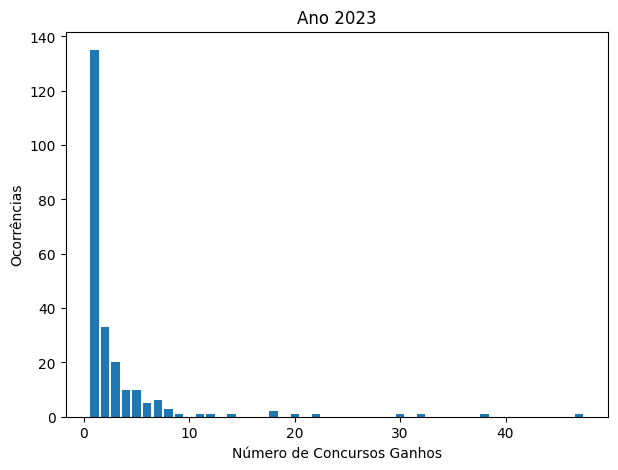

In [19]:
v = pd.Series(cp[cp.DataCel.dt.year == 2023].NIF2.value_counts()).value_counts()

plt.bar(v.index, v.values)
plt.xlabel('Número de Concursos Ganhos')
plt.ylabel('Ocorrências')
plt.title('Ano 2023')
plt.show()

In [20]:
# Determinar, para o ano de 2022, o número total de concursos públicos celebrados e o número médio de 
# contratos celebrados por entidade adjudicante
cp[cp.DataCel.dt.year == 2022].NIF2.value_counts().describe()

count    187.000000
mean       3.336898
std        6.477328
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       53.000000
Name: count, dtype: float64

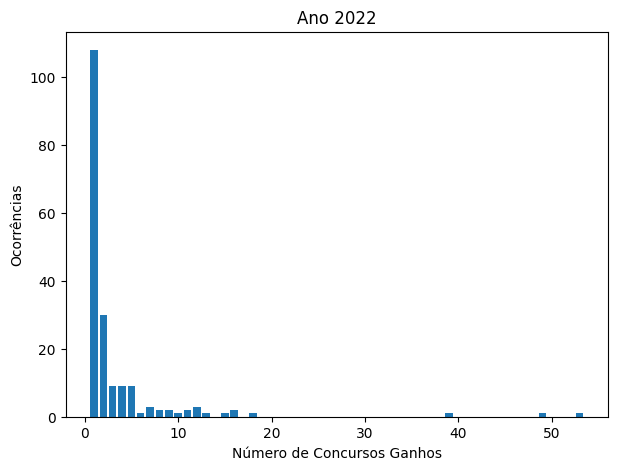

In [21]:
v = pd.Series(cp[cp.DataCel.dt.year == 2022].NIF2.value_counts()).value_counts()

plt.bar(v.index, v.values)
plt.xlabel('Número de Concursos Ganhos')
plt.ylabel('Ocorrências')
plt.title('Ano 2022')
plt.show()

<br>

<br>

<br>

***

## Gerar flag para todos os contratos públicos ganhos por uma determinada entidade adjudicatária que tenha excedido um treshold de concursos ganhos

Para cada NIF das entidades adjudicatárias, verificar quantos contratos públicos venceu num determinado ano. 

Se o número de contratos ganhos for superior a um determinado treshold é ativada uma flag em todos os contratos celebrados com esta entidade. 

Inicialmente, este treshold é definido pelo valor médio de concursos ganhos por entidade adjudicatária


<br>

**Ano 2023 :**

In [22]:
# Média de concursos públicos ganhos por entidade adjudicante a nível nacional
avg = cp[cp.DataCel.dt.year == 2022].NIF2.value_counts().mean()

# Índices dos NIFs2 cujo número de contratos celebrados é superior à media nacional de contratos celebrados
IDx = np.where(cp[cp.DataCel.dt.year == 2022].NIF2.value_counts() > avg)[0]

In [25]:
cp[cp.DataCel.dt.year == 2022].NIF2.value_counts().describe()

count    187.000000
mean       3.336898
std        6.477328
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       53.000000
Name: count, dtype: float64

In [23]:
# NIFs das entidades adjudicatórias que venceram, no ano de 2022, mais do que a média de concursos a nível nacional
NIFs = cp[cp.DataCel.dt.year == 2022].NIF2.value_counts().index[IDx]
NIFs

Index(['501774360', '504272179', '502604751', '980079659', '515777048',
       '510830536', '506360237', '510728189', '503670693', '502726890',
       '505134195', '504615947', '504729624', '502544180', '504551221',
       '509937349', '506210855', '504243926', '508775876', '503182710',
       '510874169', '503541320', '506204650', '503222364', '502309440',
       '504099388', '510098711', '501782230', '513600728', '508776058',
       '502479418', '503239917', '503536717', '505244713', '505355108',
       '509216595', '502980826', '501989978', '509733441', '504654748'],
      dtype='object', name='NIF2')

In [24]:
flag_ids = []

for i in NIFs:
    ids = cp[(cp.DataCel.dt.year == 2022) & (cp.NIF2 == i)].ID.tolist()
    flag_ids.extend(ids)
flag_ids

['9448728',
 '10238348',
 '10063214',
 '9889575',
 '9695707',
 '9599981',
 '9599980',
 '9602615',
 '9602542',
 '9602195',
 '9600900',
 '9600738',
 '9605956',
 '9605951',
 '9604483',
 '9608196',
 '9608195',
 '9610340',
 '9610332',
 '9616343',
 '9616339',
 '9618999',
 '9618884',
 '9622120',
 '9622113',
 '9624511',
 '9624510',
 '9624496',
 '9624493',
 '9624490',
 '9624481',
 '9624478',
 '9624460',
 '9624449',
 '9624401',
 '9624300',
 '9582096',
 '9582065',
 '9586728',
 '9586681',
 '9593787',
 '9593785',
 '9596095',
 '9596011',
 '9394070',
 '9392954',
 '9500426',
 '9327145',
 '9346561',
 '9349202',
 '9384361',
 '9386171',
 '9387753',
 '9421013',
 '9421738',
 '9748367',
 '9665143',
 '9690246',
 '9690223',
 '9690187',
 '9690075',
 '9690041',
 '9599982',
 '9600929',
 '9624519',
 '9624517',
 '9624513',
 '9624484',
 '9624386',
 '9623087',
 '9635034',
 '9635030',
 '9647416',
 '9647412',
 '9647769',
 '9647758',
 '9568604',
 '9571475',
 '9577651',
 '9580747',
 '9580715',
 '9581807',
 '9593791',
 '

### Filtrar por Distrito

Calcular o número médio de concursos ganhos por entidade adjudicante por distrito

**1 : Criar uma coluna da dataframe com o distrito**

In [25]:
cp = cp.rename(columns={45:'Local'})
cp['Distrito'] = cp['Local'].str.split(', ').str[1]

h(cp.head(1))

ID,NrAnuncio,PrecoBase,Prazo,4,5,6,7,8,9,10,11,12,13,14,15,DataPub,DataCel,PrecoContratual,19,Adjudicante,21,Adjudicatária,EntConcorrentes,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,Local,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,EntidadeAdjudicante,NIF1,URL1,EntidadeAdjudicataria,NIF2,URL2,Distrito
10323405,15555/2023,137670.0,6,False,6699898,13437191,2023-09-19,182,2,False,False,https://dre.pt/application/file/221829278,Anúncio de procedimento,Concurso público,Contratualização de uma Plataforma Educacional de Aprendizagem Digital,2023-11-02,2023-10-31,113524.8,332,Município de Santarém (505941350)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1785),"Artigo 20.º, n.º 1, alínea b) do Código dos Contratos Públicos","Porto Editora, S.A. (500221103)(https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=585)",None,https://www.base.gov.pt/Base4/pt/detalhe/?type=anuncios&id=356587,https://www.acingov.pt/acingovprod/2/zonaPublica/zona_publica_c/donwloadProcedurePiece/NjgwNTc4,https://www.base.gov.pt/Base4/pt/resultados/?type=doc_documentos&id=2071168&ext=.pdf,false,72212190-7,False,None,None,False,False,None,False,None,False,Aquisição de serviços,Serviços de desenvolvimento de software para ensino,Principal,113524.8,Contratualização de uma Plataforma Educacional de Aprendizagem Digital,Não aplicável,None,"Portugal, Santarém, Santarém",Não aplicável.,Não aplicável.,None,False,False,None,None,False,None,True,None,"Código dos Contratos Públicos (DL111-B/2017) e Lei n.º 30/2021, de 21.05",None,None,1699382733,Município de Santarém,505941350,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=1785,"Porto Editora, S.A.",500221103,https://www.base.gov.pt/Base4/pt/detalhe/?type=entidades&id=585,Santarém


**2 : Listar distritos com maior número de contratos celebrados**

In [26]:
cp.Distrito.value_counts()

Distrito
Lisboa                        598
Porto                         194
Porto<BR/>Portugal             92
Lisboa<BR/>Portugal            77
Setúbal                        38
Braga                          25
Aveiro                         21
Coimbra                        21
Castelo Branco                 17
Região Autónoma da Madeira     14
Viseu                          13
Vila Real                      13
Faro                           12
Viana do Castelo               11
Santarém                       11
Leiria                         10
Distrito não determinado       10
Região Autónoma dos Açores      9
Braganca                        9
Évora                           8
Beja                            6
Portugal Continental            6
Guarda                          4
Portalegre                      3
Viseu<BR/>Portugal              1
Name: count, dtype: int64

In [27]:
cp['Distrito'] = cp['Distrito'].str.replace('Porto<BR/>Portugal', 'Porto')
cp['Distrito'] = cp['Distrito'].str.replace('Lisboa<BR/>Portugal', 'Lisboa')
cp['Distrito'] = cp['Distrito'].str.replace('Viseu<BR/>Portugal', 'Viseu')

In [28]:
cp.Distrito.value_counts()

Distrito
Lisboa                        675
Porto                         286
Setúbal                        38
Braga                          25
Aveiro                         21
Coimbra                        21
Castelo Branco                 17
Região Autónoma da Madeira     14
Viseu                          14
Vila Real                      13
Faro                           12
Santarém                       11
Viana do Castelo               11
Distrito não determinado       10
Leiria                         10
Região Autónoma dos Açores      9
Braganca                        9
Évora                           8
Beja                            6
Portugal Continental            6
Guarda                          4
Portalegre                      3
Name: count, dtype: int64

In [29]:
#h(cp.loc[cp['Distrito'] == 'Portugal Continental'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0bf39d27d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0bf3e3efd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0bf3e12ed0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0bf3e50110>],
 'fliers': [],
 'means': []}

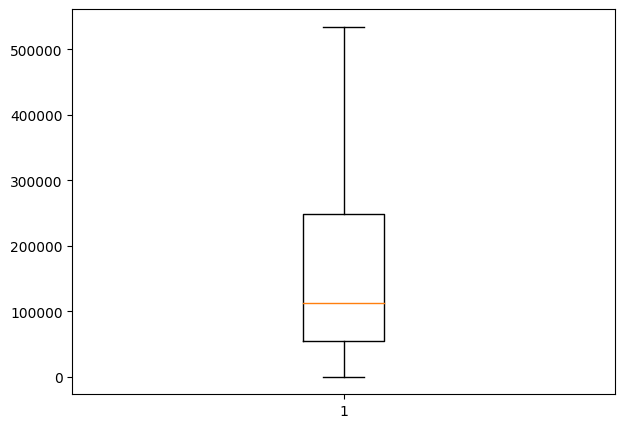

In [87]:
plt.boxplot(cp.PrecoContratual,showfliers=False)

In [88]:
cp.PrecoContratual.describe()/10**3

count        1.358000
mean       285.659743
std        889.796361
min          0.000000
25%         54.681555
50%        113.390400
75%        248.553340
max      24000.000000
Name: PrecoContratual, dtype: float64

In [93]:
print(np.quantile(cp.PrecoContratual,0.8), np.quantile(cp.PrecoContratual,0.85), np.quantile(cp.PrecoContratual,0.9), np.quantile(cp.PrecoContratual,0.¨))

308800.8000000003 399550.221 557030.0399999999 749755.4095


<br>

<br>

<br>

<br>

<br>

<br>

In [30]:
# Construir nova dataframe a partir da original mas que contenha apenas as colunas com EntAdjudicante, EntAdjudicatária e respetivos NIF's
# referente ao ano de 2023
novadf = cp.loc[cp['DataCel'].dt.year == 2023, ['ID','NrAnuncio','EntidadeAdjudicante','NIF1','EntidadeAdjudicataria','NIF2']]
novadf

,ID,NrAnuncio,EntidadeAdjudicante,NIF1,EntidadeAdjudicataria,NIF2
0,10323405,15555/2023,Município de Santarém,505941350,"Porto Editora, S.A.",500221103
1,10322139,13241/2023,Associação de Municípios para a Gestão Sustent...,501394192,OPTIMIZER – SERVIÇOS E CONSULTADORIA INFORMÁTI...,504775936
2,10324626,15934/2023,Município de Valongo,501138960,"CLARANET II SOLUTIONS, S.A.",510728189
3,10325177,1698/2023,EMEL - Empresa Municipal de Mobilidade e Estac...,503311332,"CLARANET II SOLUTIONS, S.A",510728189
5,10327340,7629/2023,Instituto Politécnico de Bragança,600013758,"Quidgest - Consultores de Gestão, S.A.",501989978
...,...,...,...,...,...,...
1348,10377550,11864/2023,iRN - Instituto dos Registos e Notariado,508184258,"AXIANSEU II DIGITAL CONSULTING, S.A.",501774360
1351,10376734,2305/2023,Secretaria-Geral do Ministério da Economia,600081125,"Reload - Consultoria Informática, Lda",506210855
1352,10376541,19394/2023,Ministério da Defesa Nacional - Marinha,600012662,INETUM ESPAÑA SA,980079659
1353,10376333,2340/2023,"Instituto de Gestão Financeira da Educação, I.P.",600086631,"Normática, Serviços de Informática e Organizaç...",501782230


In [31]:
# Print dos NIF's por ordem decrescente de ocorrência
print(novadf.NIF1.value_counts(), '\n\n')
print(novadf.NIF2.value_counts())

NIF1
509540716    163
504322915     22
510928374     16
501442600     13
600084779     11
            ... 
600082628      1
680009671      1
507142217      1
515545180      1
600081028      1
Name: count, Length: 228, dtype: int64 


NIF2
504272179    47
515777048    38
501774360    32
510728189    30
506360237    22
             ..
510474357     1
513662332     1
506396010     1
507321707     1
507477740     1
Name: count, Length: 234, dtype: int64


In [32]:
# Ordenar nova dataframe por ordem decrescente de ocorrência do NIF1 ( nif da entidade adjudicante ) 
ordem = novadf['NIF1'].value_counts().index
novadf = novadf.sort_values(by='NIF1', key=lambda x: pd.Categorical(x, categories = ordem), ignore_index=True)

In [33]:
novadf

,ID,NrAnuncio,EntidadeAdjudicante,NIF1,EntidadeAdjudicataria,NIF2
0,10103391,3295/2023,SPMS - Serviços Partilhados do Ministério da S...,509540716,"Amazon Informática, Lda",516411810
1,10170890,7679/2023,"SPMS- Serviços Partilhados do M. da Saúde, E.P.E.",509540716,INDRA III SOLUÇÕES DE TECNOLOGIA DA INFORMAÇÃO...,503222364
2,10170852,6522/2023,SPMS - Serviços Partilhados do Ministério da S...,509540716,"MARCOS BARROSA, UNIPESSOAL LDA",515371378
3,10170815,6522/2023,SPMS - Serviços Partilhados do Ministério da S...,509540716,INDRA III SOLUÇÕES DE TECNOLOGIA DA INFORMAÇÃO...,503222364
4,10170466,7588/2023,SPMS - Serviços Partilhados do Ministério da S...,509540716,Shore Spun Lda.,507902238
...,...,...,...,...,...,...
713,10157315,9009/2023,Serviços Sociais da Administração Pública,600082628,"Deloitte Processes & Operations, S.A.",502446170
714,10155193,7511/2023,Serviços Intermunicipalizados de Águas e Resíd...,680009671,"CLARANET PORTUGAL, S.A.",503412031
715,10152400,5043/2023,"Fagar - Faro, Gestão de Águas e Resíduos, E. M.",507142217,"Visionware, Sistemas de Informação, S.A.",507411072
716,10153287,5107/2023,"Hospital de Braga, EPE",515545180,"BIQ - HEALTH SOLUTIONS, LDA.",504105337


In [34]:
# Verificar, para o NIF1 com maior número de ocorrências, o número de contratos celebrados com cada um dos NIFs das entidades adjudicatárias
# Imprimir apenas para nr de contratos celebrados acima de 5
contagem = novadf.loc[novadf['NIF1'] == '509540716','NIF2'].value_counts()
contagem[contagem > 5].index

Index(['504272179', '515777048', '515371378', '501774360', '506360237',
       '503222364', '510098711'],
      dtype='object', name='NIF2')

In [35]:
for i in novadf.NIF1.value_counts().index:

    cont = novadf.loc[novadf['NIF1'] == i,'NIF2'].value_counts()

    if len(cont[cont > 5].values):
        print('NIF1 =',i)
        print(cont[cont > 5])
        print('\n\n')

    for j in cont[cont > 5].index:
        print(novadf.ID.loc[(novadf['NIF1'] == i) & (novadf['NIF2'] == j)])
        print('\n\n')
        
    cont = 0

NIF1 = 509540716
NIF2
504272179    39
515777048    31
515371378    18
501774360    16
506360237     9
503222364     8
510098711     6
Name: count, dtype: int64



7      10168662
9      10168812
16     10161511
17     10161710
18     10170971
19     10311809
24     10035765
28     10035502
33     10261915
34     10058804
35     10059039
38     10059100
45     10204451
46     10204302
53      9830082
77     10113116
82      9825462
83     10009799
86     10101016
87     10101046
88     10101077
89     10101118
100    10312468
104    10100889
105    10281057
113    10228788
116    10230288
117     9960977
118    10230326
122    10281794
125    10338918
126    10099601
128    10099668
129    10223856
141    10339729
148    10095824
149    10312472
152    10095769
159    10099869
Name: ID, dtype: object



8      10168757
15     10161447
21     10059125
23     10035794
26     10035600
27     10035549
29     10035372
30     10035314
32     10261946
36     10059063
39     10059157
41     101

In [36]:
# Ordenar nova dataframe por ordem decrescente de ocorrência do NIF2 ( nif da entidade adjudicatária ) 
ordem1 = novadf['NIF2'].value_counts().index
novadf_1 = novadf.sort_values(by='NIF2', key=lambda x: pd.Categorical(x, categories = ordem1), ignore_index=True)

In [37]:
for i in novadf_1.NIF2.value_counts().index:

    cont = novadf_1.loc[novadf_1['NIF2'] == i,'NIF1'].value_counts()

    if len(cont[cont > 5].values):
        print('NIF2 =',i)
        print(cont[cont > 5])
        print('\n\n')
        
    cont = 0

NIF2 = 504272179
NIF1
509540716    39
Name: count, dtype: int64



NIF2 = 515777048
NIF1
509540716    31
Name: count, dtype: int64



NIF2 = 501774360
NIF1
509540716    16
510928374     6
Name: count, dtype: int64



NIF2 = 506360237
NIF1
509540716    9
Name: count, dtype: int64



NIF2 = 515371378
NIF1
509540716    18
Name: count, dtype: int64



NIF2 = 502726890
NIF1
504322915    6
Name: count, dtype: int64



NIF2 = 503222364
NIF1
509540716    8
Name: count, dtype: int64



NIF2 = 510098711
NIF1
509540716    6
Name: count, dtype: int64





# Caso 1

**1** : Determinal qual o NIF da entidade adjudicante com mais contratos celebrados no ano de 2023

In [38]:
# Lista de entidades adjudicantes com mais contratos celebrados no ano de 2023
cp[(cp['DataCel'].dt.year == 2023)].NIF1.value_counts()

NIF1
509540716    163
504322915     22
510928374     16
501442600     13
600084779     11
            ... 
600082628      1
680009671      1
507142217      1
515545180      1
600081028      1
Name: count, Length: 228, dtype: int64

**2** : Determinar ID's de todos os contratos celebrados em 2023 pelo NIF = 509540716

In [39]:
ids2023 = cp[(cp['DataCel'].dt.year == 2023) & (cp['NIF1'] == '509540716')].ID

In [40]:
ids2023.values

array(['10332117', '10281794', '10281057', '10312468', '10312461',
       '10312460', '10312472', '10335594', '10335548', '10311506',
       '10338678', '10338639', '10337509', '10337405', '10337328',
       '10337213', '10223856', '10230212', '10339729', '10339365',
       '10338995', '10338918', '10261946', '10261915', '10170971',
       '10170890', '10170852', '10170815', '10170466', '10170419',
       '10188351', '10188319', '10188301', '10188270', '10204545',
       '10204451', '10204302', '10204260', '10204230', '10203906',
       '10203896', '10203881', '10207089', '10206843', '10103445',
       '10103418', '10103391', '10103347', '10103327', '10103294',
       '10106141', '10106119', '10113284', '10113260', '10113220',
       '10113116', '10112952', '10162178', '10162119', '10161854',
       '10161771', '10161710', '10161511', '10161447', '10161129',
       '10168812', '10168757', '10168662', '10059221', '10059157',
       '10059125', '10059100', '10059063', '10059039', '100588

In [41]:
cp.loc[(cp['DataCel'].dt.year == 2023) & (cp['NIF1'] == '509540716'),'NIF2'].value_counts()

NIF2
504272179    39
515777048    31
515371378    18
501774360    16
506360237     9
503222364     8
510098711     6
504665901     3
504729624     3
514436298     3
507902238     3
502604751     3
503412031     2
516411810     2
507025229     2
504615947     2
504642251     1
514756969     1
502726890     1
502605731     1
504320882     1
509117660     1
508991579     1
502479418     1
502216336     1
516064932     1
501570691     1
507969332     1
504243926     1
Name: count, dtype: int64

In [42]:
Xx = cp.loc[(cp['DataCel'].dt.year == 2023) & (cp['NIF1'] == '509540716'),'NIF2'].value_counts()

print('Número de contratos publicados :', Xx.sum())

Número de contratos publicados : 163


In [43]:
print('NIF2 \t\t NrContratos \t Rácio \t')

for i,j in enumerate(Xx):
    print(Xx.index[i], '\t',  Xx.values[i], '\t\t', np.round(Xx.values[i]/Xx.sum(),3)*100)

NIF2 		 NrContratos 	 Rácio 	
504272179 	 39 		 23.9
515777048 	 31 		 19.0
515371378 	 18 		 11.0
501774360 	 16 		 9.8
506360237 	 9 		 5.5
503222364 	 8 		 4.9
510098711 	 6 		 3.6999999999999997
504665901 	 3 		 1.7999999999999998
504729624 	 3 		 1.7999999999999998
514436298 	 3 		 1.7999999999999998
507902238 	 3 		 1.7999999999999998
502604751 	 3 		 1.7999999999999998
503412031 	 2 		 1.2
516411810 	 2 		 1.2
507025229 	 2 		 1.2
504615947 	 2 		 1.2
504642251 	 1 		 0.6
514756969 	 1 		 0.6
502726890 	 1 		 0.6
502605731 	 1 		 0.6
504320882 	 1 		 0.6
509117660 	 1 		 0.6
508991579 	 1 		 0.6
502479418 	 1 		 0.6
502216336 	 1 		 0.6
516064932 	 1 		 0.6
501570691 	 1 		 0.6
507969332 	 1 		 0.6
504243926 	 1 		 0.6


In [ ]:
indices = ((cp.ID[(cp.DataCel.dt.year == 2023) & (cp.NIF1 == '509540716')])).index

print('ID \t\t NIF \t\t NrEntidadesConcorrentes  EntidadeVencedora \t RácioConcursosGanhos')

for i in (indices):
    #print(j, '\t', cp.NIF1[i], '\t\t', len(nec[i]) + 1, '\t\t')
    print(cp.ID[i], '\t', cp.NIF1[i], '\t', len(nr_entidades(cp.ID[i])), '\t\t\t', cp.NIF2[i], '\t\t\t', np.round(nr_contrato(cp,2023,cp.NIF2[i])/len(indices)*100,2))

ID 		 NIF 		 NrEntidadesConcorrentes  EntidadeVencedora 	 RácioConcursosGanhos


In [44]:
def nr_entidades(Id):
    """
    Função que, dado o id de um contrato, retorna uma lista com as entidades concorrentes. Desta forma, podemos calcular o número de entidades concorrentes utilizando o comando len()
    Se se der como input apenas um contrato - o id deste irá ter length = 8 visto que cada ID é composto por 8 algarismos - irá ser realizado no primeiro ramo do ciclo if-else
    Se se der um tuplo de ID's irá ser calculado no segundo ramo do ciclo e será retornada uma lista de listas

    Parâmetros:
        Id : id do contrato

    return:
        result : lista com a entidades concorrentes
    """

    if len(Id) == 8:
    
        cur = conn.cursor()
        cur.execute('''
                    SELECT entidades_concorrentes
                    FROM "contratos"
                    WHERE id = %s;''', (Id,))
        
        data = cur.fetchall()
        result = data[0][0].split('|||')
    
        return result

    
    else:
        
        cur = conn.cursor()
        cur.execute('''
                    SELECT entidades_concorrentes
                    FROM "contratos"
                    WHERE id IN %s; ''', (tuple(Id),))
            
        data = cur.fetchall()
        
        n = len(data)
        r = [] 
        result = []
        
        for i in range(n):
            r = data[i][0].split('|||')
            result.append(r)
            
        return result

In [45]:
nec = nr_entidades(cp.ID)